# Homework - Analyzing Fetal ECG Signals with SVD and ICA Methods
This study explores the application and effectiveness of Singular Value Decomposition (SVD) and Independent Component Analysis (ICA) in the analysis of biomedical signals, specifically focusing on fetal ECG data. The dataset used in this analysis is derived from the "Abdominal and Direct Fetal ECG Database" (https://physionet.org/content/adfecgdb/1.0.0/) and the study primarily focuses on a single ECG file (r01.edf). 

The decision to analyze only one file was based on the consistency observed across different files, which made further analysis redundant without additional insights.

## Abdominal and Direct Fetal ECG Database
PhysioBank has received a contribution of five-minute multichannel fetal ECG recordings, with cardiologist-verified annotations of all fetal heart beats, from five women in labor, from the Medical University of Silesia, Poland. Each record includes four signals from the maternal abdomen and a simultaneously recorded reference direct fetal ECG from the fetal scalp; all signals are sampled at 1 KHz with 16-bit resolution.

<center>
    <img src="abdominal_image.jpg" alt="Illustration of a multichannel fetal ECG recording" width="350"/>
</center>

**Original publication**:
Jezewski J, Matonia A, Kupka T, Roj D, Czabanski R. >Determination of the fetal heart rate from abdominal signals: evaluation of beat-to-beat accuracy in relation to the direct fetal electrocardiogram. Biomedical Engineering/Biomedizinische Technik 2012 Jul;57(5):383-394. doi:10.1515/bmt-2011-0130.

**References**:
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
### Abstract
The research material included in the Abdominal and Direct Fetal Electrocardiogram Database contains multichannel fetal electrocardiogram (FECG) recordings obtained from 5 different women in labor, between 38 and 41 weeks of gestation. The recordings were acquired in the Department of Obstetrics at the Medical University of Silesia, by means of the KOMPOREL system for acquisition and analysis of fetal electrocardiogram (ITAM Institute, Zabrze, Poland). Each recording comprises four differential signals acquired from maternal abdomen and the reference direct fetal electrocardiogram registered from the fetal head.
### Data Description
The configuration of the abdominal electrodes comprised four electrodes placed around the navel, a reference electrode placed above the pubic symphysis and a common mode reference electrode (with active-ground signal) placed on the left leg. To reduce the skin impedance, the areas under the Ag-AgCl electrodes were abraded. In all cases, the scalp electrode was placed for a clinical indication and all women consented to participate in this study.

The acquisition of direct fetal electrocardiogram was carried out with a typical spiral electrode, commonly used in a direct FECG channel of popular fetal monitors. The R-wave locations were automatically determined in the direct FECG signal by means of on-line analysis applied in the KOMPOREL system. These locations were then verified (off-line) by a group of cardiologists, resulting in a set of reference markers precisely indicating the R-wave locations. The markers have been stored together with the direct and indirect FECG signals in EDF/EDF+ format.

The provided recordings constitute an excellent material for testing and evaluation of efficacy of new FECG processing techniques, e.g. algorithms for suppression of maternal electrocardiogram in abdominal signals or for detection of fetal QRS complexes. In the authors' studies (1-4 above), these recordings were used to evaluate the accuracy of fetal heart rate measurement and to estimate its influence on the quantification of the beat-to-beat fetal heart rate (FHR) variability.

#### Recording information:

- Signals recorded in labor, between 38 and 41 weeks of gestation
- Four signals acquired from maternal abdomen
- Direct electrocardiogram recorded simultaneously from fetal head
- Positioning of electrodes was constant during all recordings
- Ag-AgCl electrodes (3M Red Dot 2271) and abrasive material to improve skin conductance (3M Red Dot Trace Prep 2236)
- Bandwidth: 1Hz - 150Hz (synchronous sampling of all signals)
- Additional digital filtering for removal of power-line interference (50Hz) and baseline drift
- Sampling rate: 1 kHz
- Resolution: 16 bits
- Input ranges are included in the records in EDF format

## Libraries

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import heartpy as hp

## Function used

The various functions used in the code are listed below. A separate cell was chosen to gather these functions to achieve a cleaner and more organized code flow.

The description of each can be interpreted from the code and the comments used.

In [2]:
# load of the edf file
def load_edf_file(file_name):
    raw = mne.io.read_raw_edf(file_name, preload=True)
    return raw

# Use of the SVD function from scikit-learn
def apply_full_svd(data):
    
    U, Sigma, VT = np.linalg.svd(data, full_matrices=False)
    Sigma_matrix = np.diag(Sigma)
    # This formula is explained after
    svd_data = np.dot(U, np.dot(Sigma_matrix, VT))
    svd_data = svd_data.T
    return U, Sigma, VT, svd_data

def calculate_snr(svd_data, signal_components):
    # Calculate signal power (sum of the variance of the first few components)
    S = np.sum(np.sum(svd_data[:, :signal_components]**2, axis=0))
    
    
    # Calculate noise power (sum of the variance of the remaining components)
    N = np.sum(np.sum(svd_data[:, signal_components:]**2, axis=0))
    # Calculate SNR in dB
    SNR = 10 * np.log10(S / N)
    
    return SNR

def apply_ica(data, n_components):
    ica = FastICA(n_components=n_components, random_state=0)
    ica_components = ica.fit_transform(data.T)  # Transpose data for ICA
    return ica, ica_components

# BPM calculator
def calculate_bpm(signal, sampling_rate):
    _, m = hp.process(signal, sample_rate=sampling_rate)
    # Extract the BPM from the heartpy results
    bpm = m['bpm']
    
    return bpm


## Visualization of the data

In the code below it is loaded the ECG file (r01.edf) and visualized the 5 signals.

Considering these signals as periodic, the visualization of the first 10 seconds is sufficient to understand the behaviour of the ECG signals.

In [3]:
# Load the .edf file
edf_file = 'r01.edf'
raw = load_edf_file(edf_file)

Direct_1 - Estimated BPM: 128.48
Abdomen_1 - Estimated BPM: 167.24
Abdomen_2 - Estimated BPM: 180.10
Abdomen_3 - Estimated BPM: 392.16
Abdomen_4 - Estimated BPM: 137.90


c:\Users\_giov\Desktop\Universita\PoliTo\Magistrale\I_Anno\experiments\env\lib\site-packages\numpy\ma\core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\_giov\Desktop\Universita\PoliTo\Magistrale\I_Anno\experiments\env\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


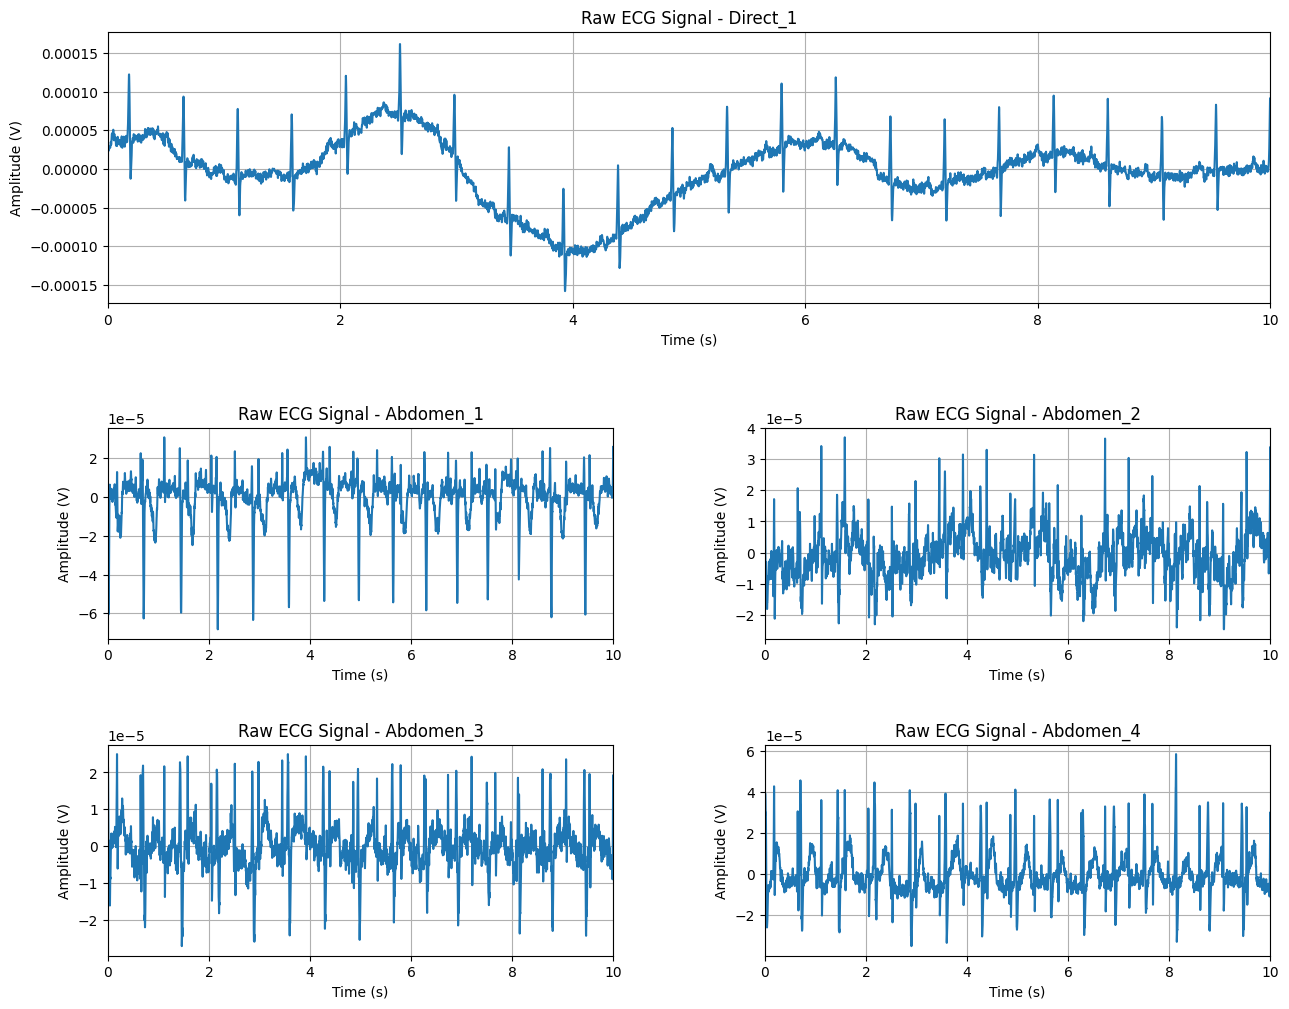

In [ ]:
# Name of the 5 channels
channel = {0:"Direct_1", 1:"Abdomen_1", 2:"Abdomen_2", 3:"Abdomen_3", 4:"Abdomen_4"}

# Get data and times from the channels
data, times = raw[:, :]
sampling_rate = 1000  # 1 kHz

# 10 seconds period chosen
period_seconds = 10
# Number of samples 
n_samples_10s = period_seconds * sampling_rate

# Get the first 10 seconds of information
data_10s = data[:, :n_samples_10s]
times_10s = times[:n_samples_10s]

# For each channel, calculate the BPM
for i in range(data_10s.shape[0]):
    bpm = calculate_bpm(data_10s[i], sampling_rate)
    print(f'{channel[i]} - Estimated BPM: {bpm:.2f}')


# Plots
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(times_10s, data_10s[0])
ax1.set_title(f'Raw ECG Signal - {channel[0]}')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (V)')
ax1.set_xlim([0, period_seconds])
ax1.grid(True)

axs = fig.add_gridspec(2, 2, top=0.55, hspace=0.5, wspace=0.3)
for i in range(1, 5):
    ax = fig.add_subplot(axs[(i-1) // 2, (i-1) % 2])
    ax.plot(times_10s, data_10s[i])
    ax.set_title(f'Raw ECG Signal - {channel[i]}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (V)')
    ax.set_xlim([0, period_seconds])
    ax.grid(True)

plt.show()

In the raw data, the heartbeat ranges from 128 to 392 bpm. For a fetus at 38-41 weeks, the expected range is between 120 and 160 bpm[1], while for the mother it ranges from 70 to 110 bpm[2]. The signals are likely overlapped, making it difficult to distinguish between the fetal and maternal heartbeats. Moreover, the presence of (muscle) noise is therefore a source of information about activity, although it reduces the amount of information about the cardiac cycle. 

Therefore, as first approach, SVD will be used to separate the signals from the noise and obtain a clearer representation.

## Singular Value Decomposition - SVD

In this section there is the Singular Value Decomposition (SVD) code implementation. 

The Singular Value Decomposition is a technique which decomposes a matrix into three other matrices, representing the original data in a different space that may reveal underlying structures not immediately apparent in the original domain. Specifically, for a real 𝑚 × 𝑛 matrix **X**, SVD is defined as 
<p style="text-align: center;"><i>X = U</i> Σ <i>V<sup>T</sup></i></p>

where:
- *U* is a 𝑚 × 𝑚 orthogonal matrix whose columns are left singular vectors.
- *Σ* is a 𝑚 × 𝑛 diagonal matrix with non-negative real numbers on the diagnal known as **singular values**.
- *V* is a 𝑛 × 𝑛 diagonal matrix whose columns are the right singular vectors.

The singular values in *Σ* are arranged in descending order and they represent the **variance** captured along each corresponding singular vector. In this analysis, it was considered the **variance** as the energy of the signal: the less important components were considered noise since the first few singular values capture most of the important structure in the data.

The first 2 orthogonal components identified by SVD are assumed to represent independent sources.


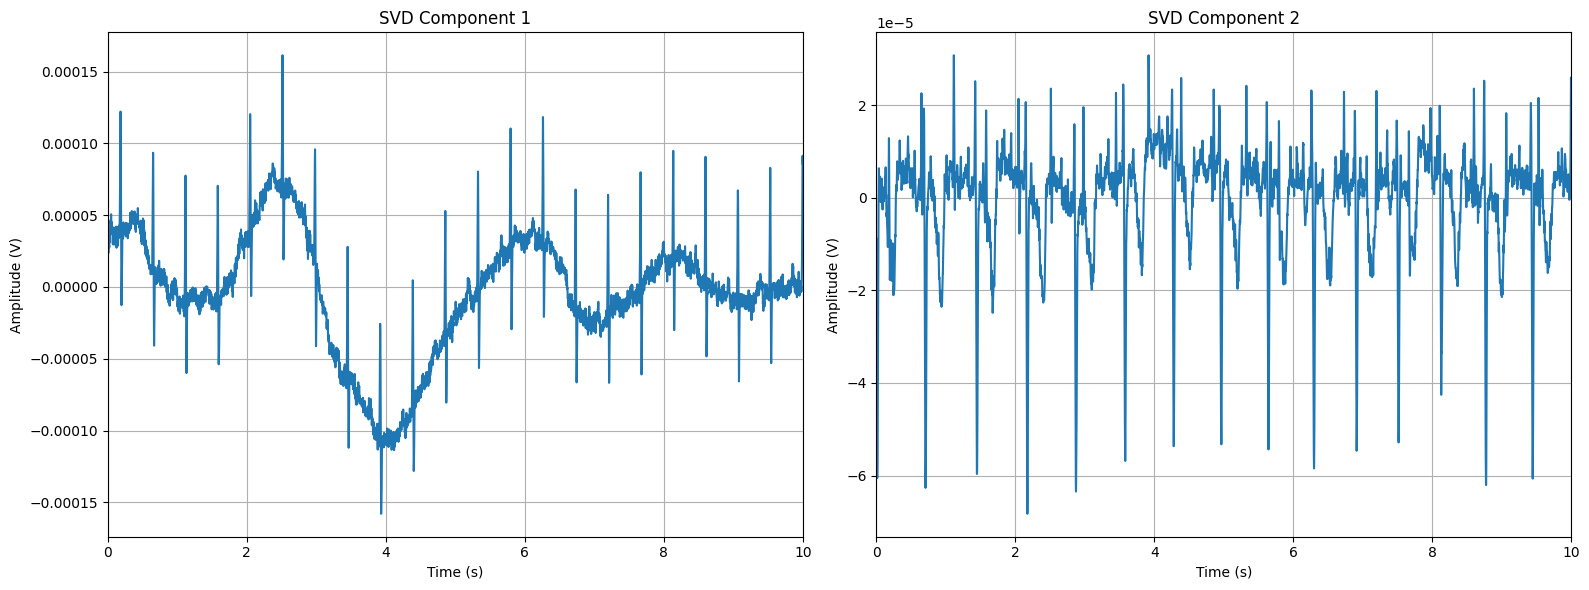

In [ ]:
#Suppose that the first two components are the orthonormal components of interest and the others are noise
n_components_svd = 2

U, Sigma, VT, svd_data = apply_full_svd(data)
# Plot    
fig, axs = plt.subplots(1, n_components_svd, figsize=(16,6))
for i in range(n_components_svd):
    axs[i].plot(times_10s, svd_data[:n_samples_10s, i])
    axs[i].set_title(f'SVD Component {i+1}')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude (V)')
    axs[i].set_xlim([0, period_seconds])
    axs[i].grid(True)
    
plt.tight_layout()
plt.show()

In [ ]:
print("BPM for SVD Components:")
for i in range(n_components_svd):
    bpm = calculate_bpm(svd_data[:, i], sampling_rate)
    print(f'SVD Component {i+1} - Estimated BPM: {bpm:.2f}')

BPM for SVD Components:
SVD Component 1 - Estimated BPM: 129.98
SVD Component 2 - Estimated BPM: 86.22


Based on the waveform shape, the first SVD component appears to correspond to the fetus's heart rate, while the second seems to represent the mother's. However, both signals are quite noisy, despite being within a reasonable range. 

It is advisable to check the Signal-to-Noise Ratio (SNR) to ensure that the signal's power is sufficient to overcome the noise[3].

In [ ]:
snr = calculate_snr(svd_data, n_components_svd)
print(f'SNR: {snr:.2f} dB')

SNR: 2.15 dB


In this scenario, the signals overlap in the *frequency domain*, resulting in a very low SNR (a good value is 60 dB, but we obtained 2.15 dB).

For these reasons, an alternative approach is used to address this problem: **Independent Component Analysis**[4].

## Indipendent Component Analysis - ICA

**Independent Component Analysis** (ICA) is a statistical method used for separating a multivariate signal into additive, independent components. It is particularly useful when the source signals are mixed in a linear manner and the goal is to recover the original sources from the observed mixtures without any prior knowledge about the mixing process.

One of the most intuitive examples used to explain ICA is the Cocktail Party Problem. Imagine being at a party where multiple conversations are happening simultaneously, and you have several microphones placed around the room. Each microphone captures a mixture of all the conversations (sources). The challenge is to isolate each individual conversation from these mixed signals without knowing the original positions or characteristics of the speakers. This is a classic example of **Blind Source Separation** (BSS), where ICA can be applied to separate these independent sources.

Consider **$X_{jn} $** to be a matrix of observed $\textit{j}$ observed random vectors, **A** a 𝑛 × $\textit{j}$ mixing matrix and **Z**, the $\textit{j}$ (assumed) source vectors such that
<div style="text-align: center;">X<sup>T</sup> = A Z<sup>T</sup></div>

ICA algorithms attempt to find a separating or demixing matrix **W** such that
<div style="text-align: center;">Y<sup>T</sup> = W X<sup>T</sup></div>

where **W** = **$\hat{A}^{-1}$**, an approximation of the inverse of the original mixing matrix, and **$Y^T$** = **$\hat{Z}^T$**, an $\textit{m}$ × $\textit{j}$ matrix, is an approximation of the underlying sources.

We can consider the **three** sources (maternal heartbeats, fetus heartbeats and muscular noise) as **non-Gaussian** and **statistically independent** sources. Unlike the Singular Value Decomposition, which rely on second-order statistics (like variance) and orthogonality, ICA can separate sources based on higher-order statistics (for example, *kurtosis*, fourth order momentum) and does not require orthogonal components.

ICA Component 1 - Estimated BPM: 82.17
ICA Component 2 - Estimated BPM: 187.08
ICA Component 3 - Estimated BPM: 130.51


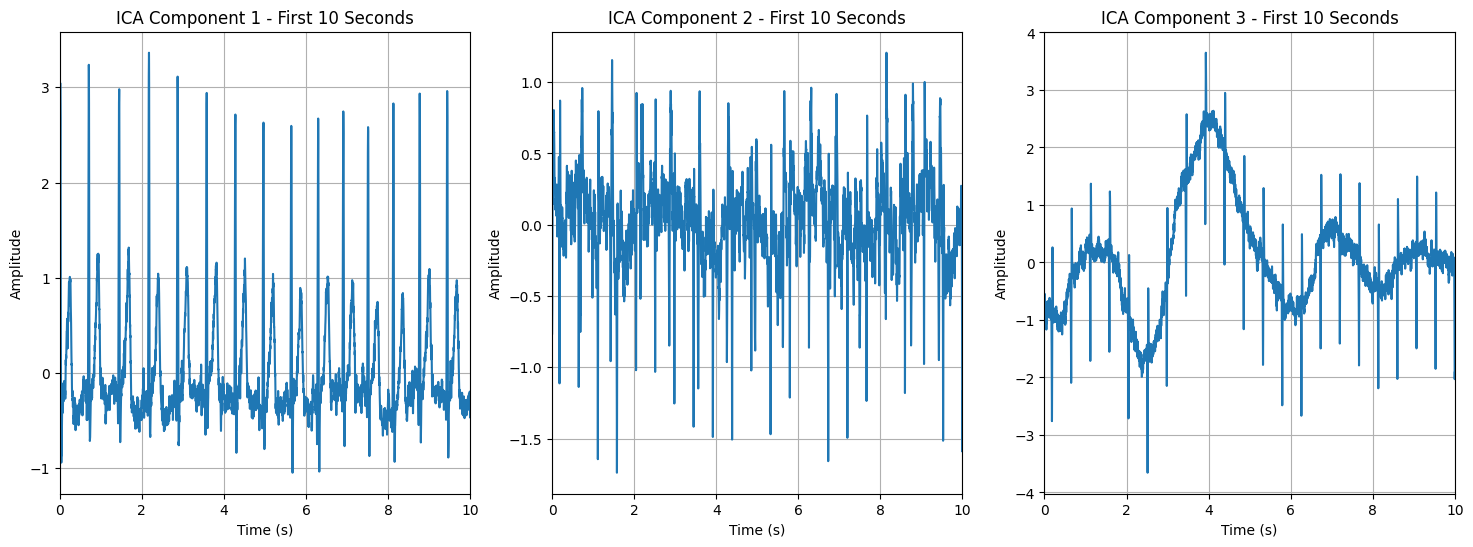

In [ ]:
# 3 components: maternal heartbeats, fetus heartbeats and muscular noise
n_components_ica = 3

ica, Y = apply_ica(data=data, n_components=n_components_ica)

# BPM calculation
for i in range(n_components_ica):
    component = Y[:, i]
    bpm = calculate_bpm(component, sampling_rate)
    print(f'ICA Component {i+1} - Estimated BPM: {bpm:.2f}')

# plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].plot(times_10s, Y[:n_samples_10s, 0])
axs[0].set_title('ICA Component 1 - First 10 Seconds')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlim([0, 10])
axs[0].grid(True)

axs[1].plot(times_10s, Y[:n_samples_10s, 1])
axs[1].set_title('ICA Component 2 - First 10 Seconds')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_xlim([0, 10])
axs[1].grid(True)

axs[2].plot(times_10s, Y[:n_samples_10s, 2])
axs[2].set_title('ICA Component 3 - First 10 Seconds')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
axs[2].set_xlim([0, 10])
axs[2].grid(True)




It is evident that ICA Component 2 represents noise. The waveform appears random, and the calculated BPM falls outside any plausible range for a healthy patient. Therefore, this component can be identified as noise.

The component with the lower heartbeat is attributed to the mother, while the one with the higher heartbeat corresponds to the fetus, both falling within expected and reasonable ranges.

In [ ]:
noise_component_index = 1
maternal_component_index = 0 
fetal_component_index = 2

## Signal Reconstruction

To reconstruct the signals, the independent components **Y** are multiplied by the transpose of the mixing matrix **W**:
<div style="text-align: center;">Z = Y W<sup>T</sup></div>



In [ ]:
W = ica.mixing_
Z = np.dot(Y, W.T)

Then, zero out the noise component

In [ ]:
Z[:, noise_component_index] = 0

Finally, project back to the *original signal space*

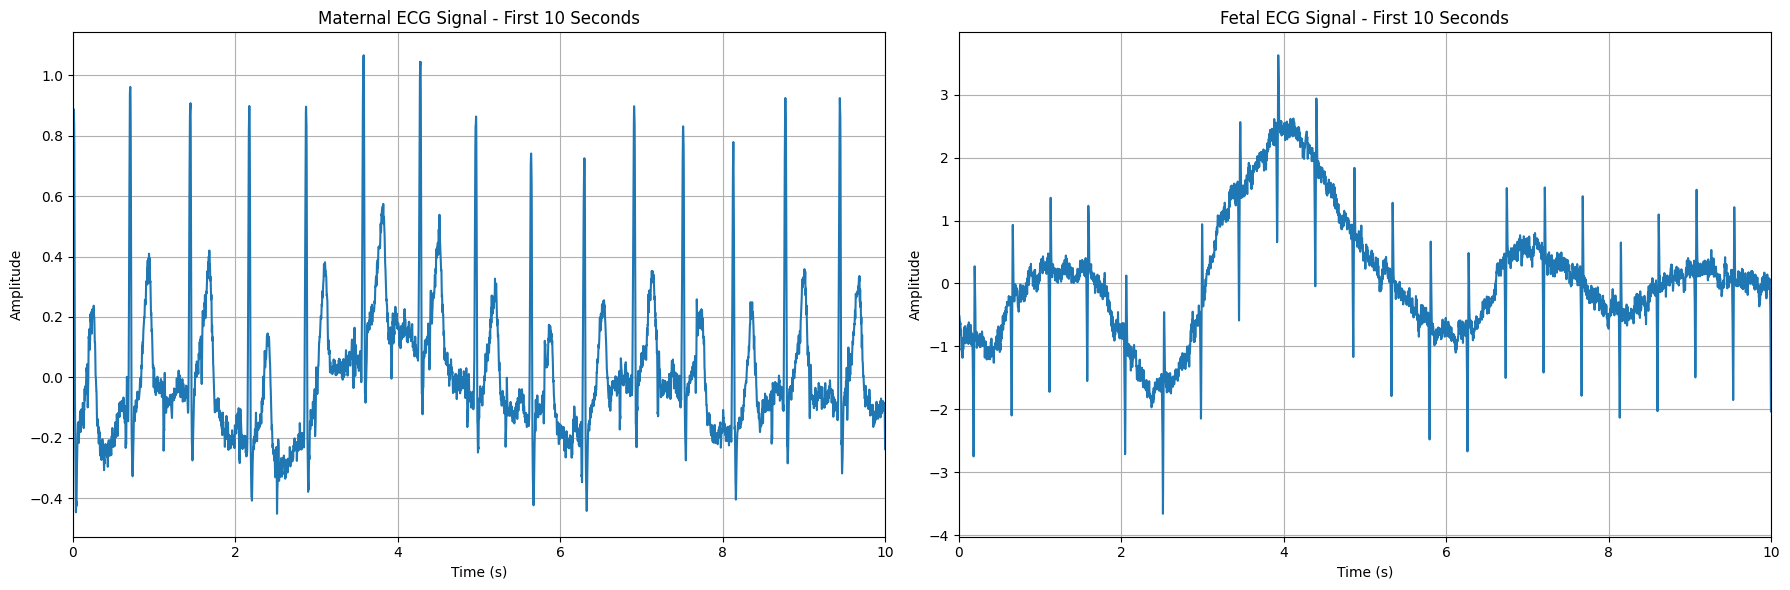

In [ ]:
# Project back to the original signal space
filtered_data = np.dot(Z, np.linalg.pinv(W.T))

maternal_signal = filtered_data[:, maternal_component_index]
fetal_signal = filtered_data[:, fetal_component_index]

# Plots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].plot(times_10s, maternal_signal[:n_samples_10s])
axs[0].set_title('Maternal ECG Signal - First 10 Seconds')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlim([0, 10])
axs[0].grid(True)

axs[1].plot(times_10s, fetal_signal[:n_samples_10s])
axs[1].set_title('Fetal ECG Signal - First 10 Seconds')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_xlim([0, 10])
axs[1].grid(True)

plt.tight_layout()
plt.show()

Now that the signal is filtered, it is possible to evaluate the BPM for both signals.

In [ ]:
bpm = calculate_bpm(maternal_signal, sampling_rate)
print(f'Maternal ECG\t - \tEstimated BPM: {bpm:.2f}')
bpm = calculate_bpm(fetal_signal, sampling_rate)
print(f'Fetal ECG\t - \tEstimated BPM: {bpm:.2f}')

Maternal ECG	 - 	Estimated BPM: 81.98
Fetal ECG	 - 	Estimated BPM: 130.26


## Conclusion

In this analysis, it was applied both Singular Value Decomposition (SVD) and Independent Component Analysis (ICA) to separate maternal and fetal ECG signals from a composite ECG recording. Both techniques were successful in isolating the signals of interest, and the results were comparable, demonstrating that both SVD and ICA are valid and effective methods for this type of signal separation.

After filtering the signals and removing noise components, the estimated BPM values were 81.98 for the maternal ECG and 130.26 for the fetal ECG (ICA results), which are within clinically reasonable ranges for a healthy mother and fetus.

This outcome highlights the robustness of both SVD and ICA in extracting meaningful biomedical signals from complex and mixed recordings. While the two approaches yielded similar results, ICA may offer advantages in scenarios where non-Gaussianity is a key factor. Nonetheless, both methods provide valuable tools for analyzing maternal and fetal health.

### References

1. **Karlen, W., et al. (2013)** "Multiparameter Respiratory Rate Estimation from the Photoplethysmogram." *IEEE Transactions on Biomedical Engineering* Available at: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3678114/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3678114/)
2. **BMC Medicine - Trends of blood pressure and heart rate in normal pregnancies: a systematic review and meta-analysis**: [Link to the article](https://bmcmedicine.biomedcentral.com/articles/10.1186/s12916-018-1075-1)
3. **D. H. Johnson**, *“Signal-to-noise ratio”*, Scholarpedia, vol. 1, no. 12, p. 2088, 2006. revision #126771.
4. **Clifford, G. D. (2005)**. *Singular Value Decomposition & Independent Component Analysis for Blind Source Separation*. HST582J/6.555J/16.456J Biomedical Signal and Image Processing, MIT. Available at: [https://www.mit.edu/~gari/teaching/6.222j/ICASVDnotes.pdf].